## Building a Document Retrieval and Question Answering System Using LangChain

In this project, our goal is to develop a comprehensive system for retrieving pertinent information from a collection of PDF documents and responding to questions based on the retrieved content. We will leverage LangChain, a powerful toolkit, for streamlined document processing, vectorization, and retrieval tasks. The project pipeline encompasses several key stages:

### 1. Loading and Preprocessing PDF Documents

We initiate the process by loading our PDF documents and performing preprocessing steps to extract relevant text chunks. This phase includes:

- Parsing PDF files to extract textual content.
- Segmenting the extracted text into manageable chunks for further processing.

### 2. Vectorization and Storage

Subsequently, we transform the segmented text chunks into vector representations using advanced language models such as BERT or Universal Sentence Encoder. These vectors are then stored in a dedicated vector database, such as FAISS, CHROMA, or PINECONE, to facilitate efficient retrieval.

### 3. Retrieval Augmented Generation Pipeline

Our pipeline incorporates a sophisticated mechanism for retrieving pertinent text chunks based on user queries and utilizing them to provide context for generating precise answers. This stage comprises the following steps:

- Embedding user queries into vector representations.
- Retrieving similar text chunks from the vector database.
- Ranking the retrieved chunks based on their relevance to the user query.
- Employing the retrieved chunks as contextual information for a large language model (LLM) to generate accurate answers.

### 4. Question Answering Bot

Lastly, we construct a question-answering bot that leverages the retrieved text chunks and user queries to generate informative answers. This phase encompasses:

- Providing the user question and relevant context to the LLM.
- Generating answers based on the supplied context.
- Presenting the generated answers to the user in a comprehensible format.

At first we will use a sigle pdf for the bot then we will use multiple pdf files for processing for the chatbot. Chatbot will generte answer based on the context of the pdf files and with the response of openai api.


## Install Imports and API Keys

We need to make sure our environment has the following packages:

- Install `langchain`
- Install `tiktoken`, `wikipedia`, `pypdf`, `faiss-cpu`, `pinecone-client`.

In [127]:
!pip install langchain
!pip install tiktoken
!pip install pypdf
!pip install faiss-cpu
!pip install pinecone-client

In [128]:
!pip install openai
!pip install langchain_community
!pip install langchain_openai

In [129]:
import os
from getpass import getpass

### Environments. Pinecone is a vector database that can store our data with its metadata.
We will need:
- OpenAI API Key.(5.00$ credit for first time use)
- Pinecone API Key and environment.(one free project)

At first, lets create the environments.

In [130]:
# use your openai api key
from getpass import getpass

OPENAI_API_KEY = getpass()

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY # give the openai api key

··········


In [154]:
# use your pinecone api key

PINECONE_API_KEY = getpass()

os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY

··········


In [132]:
# pinecone env key
PINECONE_ENV_KEY = getpass()

os.environ["PINECONE_ENV_KEY"] = PINECONE_ENV_KEY

··········


In [133]:
# Basics

import pandas as pd
import matplotlib.pyplot as plt

# LangChain Training
# LLM
from langchain_community.llms import OpenAI

# Document Loader
from langchain_community.document_loaders import PyPDFLoader

# Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
#This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.
# Tokenizer
from transformers import GPT2TokenizerFast

# Embedding
from langchain_community.embeddings import OpenAIEmbeddings

# Vector DataBase
from langchain_community.vectorstores import FAISS, Pinecone # for the vector database part -- FAISS is local and temporal, Pinecone is cloud-based and permanent.

# Chains
#from langchain.chains.question_answering import load_qa_chain
#from langchain.chains import ConversationalRetrievalChain

## LangChain library and their usages
The LangChain library encompasses various elements to facilitate the development of intricate applications using LangChain. This module will primarily delve into the following components:

**Loading and Processing Documents:**
- Document Loaders: Tools for loading documents into the system.
- Text Splitters: Components for breaking down text into smaller segments.
- Chat Messages: Functionality for managing messages within the chat interface.

**Interacting with Documents Using NLP:**
- LLM Model (GPT, Llama...): Advanced language models for understanding and generating text.
- Chains: Mechanisms for organizing and processing text chains.
- Natural Language Retrieval: Techniques for retrieving information based on natural language queries.
- Metadata and Indexes: Structures for storing additional information about documents.
- Memory: Functions for retaining context and information throughout interactions.

**Processes Involving Document Handling and NLP:**
- Text Embedding (OpenAI or Open-source models): Techniques for converting text into numerical representations.
- Vector Stores: Databases for storing and retrieving vectorized representations of text.


### The Model - Large Language Model of our Choice

Our chatbot employs a sophisticated Large Language Model (LLM) powered by artificial intelligence. This model functions by receiving textual input and generating corresponding textual responses. While the default model is ada-001, we retain the flexibility to explicitly select a model of our preference. For a comprehensive list of available models, please refer to the [documentation](https://platform.openai.com/docs/models).


In [22]:
import openai
from openai import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAI
#from langchain_community.llms import OpenAI
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

### Creating a Directory

To begin, a directory named 'doc' has been created. This directory serves as the repository for uploading PDF files. Initially, we will focus on a single PDF file for query-response operations. Subsequently, we will expand our scope to encompass the entire directory of files in the development of our chatbot.

In [ ]:

# Specify the output directory
output_directory = "/content/doc"

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

In [205]:
from langchain_openai import OpenAI
#from langchain_community.llms import OpenAI

#from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

llm = OpenAI()
chat_model = ChatOpenAI()

## Loading the PDF

To facilitate the loading of documents, we have imported PyPDFLoader and PyPDFDirectoryLoader modules. These modules enable us to efficiently load individual PDF documents and entire directories containing multiple PDFs.


In [135]:
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader

##We can use PyPDFLoader to load more than one PDF at once.
pdf_loader=PyPDFLoader("/content/doc/codegen.pdf")
pdf_data=pdf_loader.load()

#We can use a directory loader to load more than one PDF at once.
dir_loader = PyPDFDirectoryLoader("/content/doc/")
pdf_directory_data = dir_loader.load()

In this approach, the PyPDFLoader is used at first for loading a single pdf file then the PyPDFDirectoryLoader class is used to directly load and split PDF files from a directory.

### Text Splitter

In the context of building an LLM-based application, efficient handling of data is essential. This involves dividing the data into manageable portions known as data chunks, with the size of these chunks significantly impacting the quality of the chatbot.

The tokenizer assumes a pivotal role in managing data chunks when working with LLMs:
- **Tokenizer**: This tool is used for converting text data into a format that can be processed by the model.
- The data, once tokenized, is then stored in vector stores.

For the conversion of original data into tokens and subsequent splitting into data chunks, we employ the **LangChain Text Splitter**.



Here, we initialize a GPT-2 tokenizer using the GPT2TokenizerFast class from the Hugging Face transformers library. This tokenizer is responsible for tokenizing the text into tokens. We set truncation=True to ensure that long sentences are truncated to fit the model's input size.

The `count_tokens` function takes a string of text as input and returns the number of tokens after tokenization using the initialized tokenizer. It utilizes the `tokenizer.encode(text)` method to tokenize the text and then returns the length of the resulting list of tokens.


In [136]:
#PDF DATA
# 1 - Splitter


# 3 - Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# 4 - Define the splitter for 1 pdf
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=count_tokens
)

# 5 - Apply the .split_document command
pdf_chunks = text_splitter.split_documents(pdf_data)
print("PDF Data - Now you have {0} number of chunks.".format(len(pdf_chunks)))

# 4 - Define the splitter pdf doc
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20
)

pdf_directory_chunks = text_splitter.split_documents(pdf_directory_data)
print("pdf_directory_data - Now you have {0} number of chunks.".format(len(pdf_directory_chunks)))

PDF Data - Now you have 139 number of chunks.
pdf_directory_data - Now you have 2161 number of chunks.


In [137]:
tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")
def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# 4 - Define the splitter for 1 pdf
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=count_tokens
)

# 5 - Apply the .split_document command
pdf_chunks = text_splitter.split_documents(pdf_data)
print("PDF Data - Now you have {0} number of chunks.".format(len(pdf_chunks)))

# 4 - Define the splitter pdf doc
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20
)

pdf_directory_chunks = text_splitter.split_documents(pdf_directory_data)
print("pdf_directory_data - Now you have {0} number of chunks.".format(len(pdf_directory_chunks)))

PDF Data - Now you have 139 number of chunks.
pdf_directory_data - Now you have 2161 number of chunks.


We can make sure that the chunking has been successful by visualizing the distribution of chunk sizes.
Since we have selected a chunk size of 200, **the majority of our chunks should have this lenght.** However, to plot the chunk sizes, you should plot the distribution of the chunk lengths rather than the token counts.

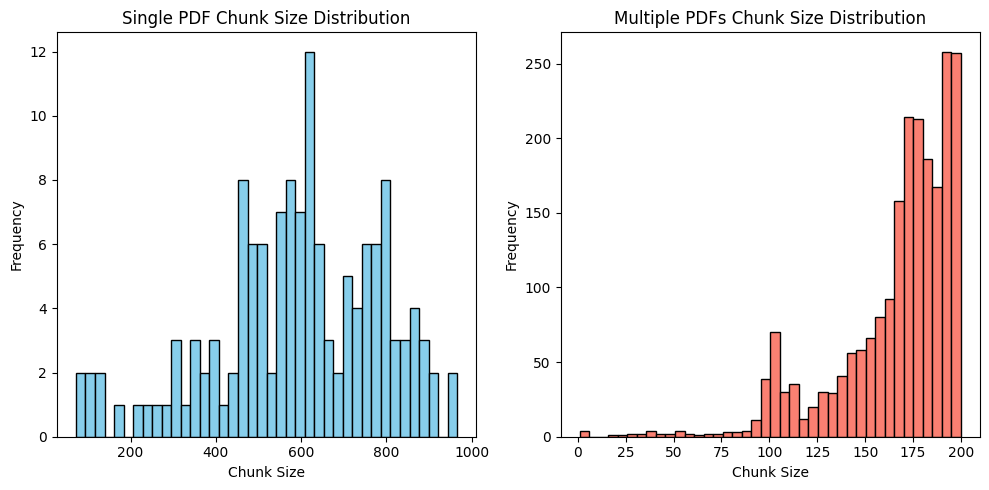

In [143]:
import matplotlib.pyplot as plt

# Create a list of chunk sizes
chunk_sizes_pdf = [len(chunk.page_content) for chunk in pdf_chunks]
chunk_sizes_pdf_directory = [len(chunk.page_content) for chunk in pdf_directory_chunks]

# Create DataFrames from the chunk sizes
df_pdf = pd.DataFrame({'Chunk Size': chunk_sizes_pdf})
df_pdf_directory = pd.DataFrame({'Chunk Size': chunk_sizes_pdf_directory})

# Plot the histogram of chunk size distributions
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df_pdf['Chunk Size'], bins=40, color='skyblue', edgecolor='black')
plt.title('Single PDF Chunk Size Distribution')
plt.xlabel('Chunk Size')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_pdf_directory['Chunk Size'], bins=40, color='salmon', edgecolor='black')
plt.title('Multiple PDFs Chunk Size Distribution')
plt.xlabel('Chunk Size')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In this histogram, the x-axis represents the chunk lengths, while the y-axis represents the frequency of each length. The blue bars represent the distribution of chunk lengths for the pdf file, and the red bars represent the distribution of the whole documentary. By comparing these two distributions, we can see how the changes in parameters affected the resulting chunk lengths.
The ideal distribution depends on the specific requirements of our text-processing task. WE might want smaller, more numerous chunks if we're dealing with fine-grained analysis or larger, fewer chunks for broader semantic analysis.


- **Split by pages**: If our data comes from documents organized in pages, there are methods that allow you to split data in pages to keep track of the page content. This method is specially useful when dealing with PDFs, as in the following example:

In [145]:

# Directory containing PDF files
pdf_directory = "/content/doc"

# Initialize an empty list to store PDF chunks
pdf_dir_page_chunks = []

# Loop through each file in the directory
for filename in os.listdir(pdf_directory):
    # Check if the file is a PDF
    if filename.endswith(".pdf"):
        # Construct the full path to the PDF file
        pdf_file_path = os.path.join(pdf_directory, filename)
        # Initialize PyPDFLoader with the PDF file
        loader = PyPDFLoader(pdf_file_path)
        # Load and split the PDF file
        pdf_file_chunks = loader.load_and_split()
        # Extend the list of PDF chunks with the chunks from the current file
        pdf_dir_page_chunks.extend(pdf_file_chunks)

# Output the number of chunks obtained
print("Total number of PDF chunks:", len(pdf_dir_page_chunks))


Total number of PDF chunks: 141
Total number of PDF chunks: 141


In this approach, each PDF file in the directory is processed individually. For each file, the code constructs the full path to the PDF file, initializes a PyPDFLoader instance with the file, loads and splits the PDF file using loader.load_and_split(), and then extends the list of PDF chunks with the chunks obtained from the current file. Finally, the total number of PDF chunks obtained is outputted.

A sample comparism between larger chunk size and smaller chunk size.

| **Model Performance**      | **Memory and Resource Usage** |
|---------------------------|-------------------------------|
| Larger chunk sizes may result in better performance by considering more context. | Larger chunk sizes require more memory and computational resources. |
| Smaller chunk sizes are preferable for fine-grained analysis and resource-constrained environments. | Smaller chunk sizes help mitigate memory issues and reduce computational burden. |
|                          |                               |
| **Speed and Efficiency**   | **Task Specificity**          |
|---------------------------|-------------------------------|
| Smaller chunk sizes may lead to faster processing times and increased efficiency. | The optimal chunk size varies depending on the NLP task and data characteristics. |
| Considerations include parallelization, distribution, and processing overhead. | Chunk size impacts tasks like NER, sentiment analysis, and document classification differently. |


## Vector Stores

Vector stores, also known as vector databases, are specialized types of databases designed to efficiently handle and manipulate high-dimensional vector data. In our case, we will store the tokenized and splitted content, e.g., the data chunks in the format that LLMs can process.

There are different types of vector stores. Depending on the storage of the data, we can classify them as:
- **Local Vector Stores**: This type of databases store the information in your local system. As an example of Local Vector Store, we will use FAISS.
- **Online Vector Stores**: This type of databases store the information in the cloud. We will use Pinecone as out preferred option for Online Vector Stores.



### FAISS - EXAMPLE OF LOCAL VECTOR STORE


We have imported the `FAISS` module from `langchain_community.vectorstores` for the vector database part. It's worth noting that FAISS is a local and temporary solution, while Pinecone is a cloud-based alternative.

The code `embeddings = OpenAIEmbeddings()` initializes an embedding model using the `OpenAIEmbeddings` class.

We have created two separate vector databases using FAISS: `db_FAISS_pdf` for storing documents loaded from individual PDF chunks, and `db_FAISS_dir` for storing documents from the directory of PDFs, both utilizing the initialized `embeddings` model.


In [148]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OpenAIEmbeddings

# Get embedding model
embeddings = OpenAIEmbeddings()

db_FAISS_pdf= FAISS.from_documents(pdf_chunks, embeddings)
db_FAISS_dir= FAISS.from_documents(pdf_directory_chunks, embeddings)

### PINECONE - EXAMPLE OF ONLINE VECTOR STORE

We utilized the `Pinecone` module from `langchain_pinecone` to create vector databases for storing documents. The `index_name` variable is set to "chtbt-documents" for both databases to identify them within the Pinecone platform.

The  `db_Pinecone_pdf` creates a Pinecone vector database named  from the documents loaded from individual PDF chunks, utilizing the provided embeddings and the specified index name.

Similarly, `db_Pinecone_dir` creates another Pinecone vector database named `db_Pinecone_dir` for documents from the directory of PDFs, also utilizing the embeddings and index name.


In [109]:
#from langchain.vectorstores import Pinecone

In [149]:
pip install langchain_pinecone

In [155]:
import langchain_pinecone

In [222]:
from langchain_pinecone import Pinecone

index_name = "chtbt-documents"

db_Pinecone_pdf= Pinecone.from_documents(pdf_chunks, embeddings, index_name=index_name)


In [223]:
db_Pinecone_pdf

## PDF FILE Natural Language Retrieval
We first start performing a semantic search within our Vector DataBase.

In [230]:

# We can define how many similarities we want to get back by defining the variable k
query = "Can you please tell me what is this article CODEGEN: AN OPEN LARGE LANGUAGE MODEL FOR CODE WITH MULTI-TURN PROGRAM SYNTHESIS is about?"
matches = db_FAISS_pdf.similarity_search(query, k=2)
print(matches)

[Document(page_content='Published as a conference paper at ICLR 2023\nCODEGEN: ANOPEN LARGE LANGUAGE MODEL FOR\nCODE WITH MULTI -TURN PROGRAM SYNTHESIS\nErik Nijkamp∗, Bo Pang∗, Hiroaki Hayashi∗,\nLifu Tu ,Huan Wang ,Yingbo Zhou ,Silvio Savarese ,Caiming Xiong\nSalesforce Research\nABSTRACT\nProgram synthesis strives to generate a computer program as a solution to a given\nproblem speciﬁcation, expressed with input-output examples or natural language\ndescriptions. The prevalence of large language models advances the state-of-the-art\nfor program synthesis, though limited training resources and data impede open\naccess to such models. To democratize this, we train and release a family of large', metadata={'source': '/content/doc/codegen.pdf', 'page': 0, 'text': 'Published as a conference paper at ICLR 2023\nCODEGEN: ANOPEN LARGE LANGUAGE MODEL FOR\nCODE WITH MULTI -TURN PROGRAM SYNTHESIS\nErik Nijkamp∗, Bo Pang∗, Hiroaki Hayashi∗,\nLifu Tu ,Huan Wang ,Yingbo Zhou ,Silvio Savarese ,Caim

In [235]:
# We can define how many similarities we want to get back by defining the variable k
query = "Can you please tell me what is this article CODEGEN: AN OPEN LARGE LANGUAGE MODEL FOR CODE WITH MULTI-TURN PROGRAM SYNTHESIS is about?"
matches = db_FAISS_pdf.similarity_search(query, k=3)
display(matches[0].page_content)

'Published as a conference paper at ICLR 2023\nCODEGEN: ANOPEN LARGE LANGUAGE MODEL FOR\nCODE WITH MULTI -TURN PROGRAM SYNTHESIS\nErik Nijkamp∗, Bo Pang∗, Hiroaki Hayashi∗,\nLifu Tu ,Huan Wang ,Yingbo Zhou ,Silvio Savarese ,Caiming Xiong\nSalesforce Research\nABSTRACT\nProgram synthesis strives to generate a computer program as a solution to a given\nproblem speciﬁcation, expressed with input-output examples or natural language\ndescriptions. The prevalence of large language models advances the state-of-the-art\nfor program synthesis, though limited training resources and data impede open\naccess to such models. To democratize this, we train and release a family of large'

In [238]:
query2 = "Can you please tell me the findings of the artcile CODEGEN?"
matches2 = db_FAISS_pdf.similarity_search(query2, k=3)
print(matches2[0].page_content)

Published as a conference paper at ICLR 2023
BROADER IMPACT AND ETHICAL CONSIDERATIONS
All variants of CODEGENare ﬁrstly pre-trained on the Pile, which includes a small portion of
profane language. Focusing on the GitHub data that best aligns our expected use case of program
synthesis, Gao et al. (2020) report that 0.1% of the data contained profane language, and has sentiment
biases against gender and certain religious groups. Thus, while we did not observe in our samples,
CODEGENmay generate such content as well. In addition to risks on natural language outputs
(e.g., docstrings), generated programs may include vulnerabilities and safety concerns, which are not
remedied in this work. Models should not be used in applications until being treated for these risks.
REFERENCES


In [239]:
# ONLINE - PINECONE

# 1. Define our query of interest.
query = "Can you please tell me what is this article CODEGEN: AN OPEN LARGE LANGUAGE MODEL FOR CODE WITH MULTI-TURN PROGRAM SYNTHESIS is about?"
# 2. Perform the semantic search in our vector database with the similarity_search command.
matches = db_Pinecone_pdf.similarity_search(query, k=2)

# 3. Define a load_qa_chain.
chain = load_qa_chain(chatgpt, chain_type="stuff")

# 4. Execute the chain with the prompt and the matches.
chain.run(input_documents=matches, question = query)


'The article "CODEGEN: AN OPEN LARGE LANGUAGE MODEL FOR CODE WITH MULTI-TURN PROGRAM SYNTHESIS" discusses the development and release of a family of large language models called CODEGEN, trained on natural language and programming language data. These models, with up to 16.1B parameters, aim to advance the state-of-the-art in program synthesis. The paper explores the use of these models for zero-shot Python code generation and investigates a multi-step paradigm for program synthesis, where a single program is broken down into multiple prompts. Additionally, the authors introduce a benchmark called Multi-Turn Programming Benchmark (MTPB) to evaluate the effectiveness of multi-turn prompts in program synthesis. The article emphasizes the importance of democratizing access to large language models for program synthesis.'

In [240]:
query2="who are the authors of this article CODEGEN: AN OPEN LARGE LANGUAGE MODEL FOR CODE WITH MULTI-TURN PROGRAM SYNTHESIS?"
matches2 = db_Pinecone_pdf.similarity_search(query2, k=3)
chain.run(input_documents=matches2, question = query2)

'The authors of the article "CODEGEN: AN OPEN LARGE LANGUAGE MODEL FOR CODE WITH MULTI-TURN PROGRAM SYNTHESIS" are Erik Nijkamp, Bo Pang, and Hiroaki Hayashi.'


When we upload data to our vector database, there is metadata that allows us to understand where the data is coming from.
When dealing with PDFs, the source information allows us to know what pdf and page the info is coming from.

Now it is the time to put it all together and generate a simple pipeline to query our documents using a LLM model.

In [242]:


# Check similarity search is working
query = "Who created transformers?"
matches = db_FAISS_dir.similarity_search(query)
print("We found {0} number of similarities.".format(len(matches)))
for match in matches:
    display("\n", match.page_content)

We found 4 number of similarities.


'\n'

'Dehghani, M., Gouws, S., Vinyals, O., Uszkoreit, J., and Łukasz\nKaiser. Universal transformers, 2019.\nDevlin, J., Uesato, J., Bhupatiraju, S., Singh, R., rahman Mohamed,'

'\n'

'Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit,\nand Neil Houlsby. An image is worth 16x16 words: Transformers for image recognition at scale.'

'\n'

'To the best of our knowledge, however, the Transformer is the first transduction model relying\nentirely on self-attention to compute representations of its input and output without using sequence-'

'\n'

'the effort to evaluate this idea. Ashish, with Illia, designed and implemented the first Transformer models and'

# Talking with our documents

##  DEFINE A CHAIN AND PERFORM THE SIMILARITY SEARCH
Generating a simple pipeline to query our documents with a load_qa_chain.

1. Import the `load_qa_chain`from the langchain.chains.question_answering library.
2. Define a prompt of interest, like: "Can you please tell me all the autors of the article Attention is all you need?"
3. Define the chain.
4. Perform a semantic search with the `.similarity_search`.
5. Execute the chain.

### Using FAISS and openai

In [244]:

# 2. Define a prompt of interest.
query = "Can you please tell me  the autors of the article 'Evaluating Large Language Models Trained on Code'?"

# 3. Define the chain
chain = load_qa_chain(llm, chain_type="stuff")

# 4. Perform a similarity search.
matches = db_FAISS_dir.similarity_search(query, k=1)

# 5. Execute the chain to obtain a NLP based response.
response = chain.run(input_documents = matches, question = query)
print(response)

 Mark Chen, Jerry Tworek, Heewoo Jun, Qiming Yuan, and Henrique Ponde de Oliveira Pinto.


Now that we already have a working pipeline to query our documents, we want to understand where our data is coming from.

In [249]:
# 1. Import the load_qa_chain
from langchain.chains.question_answering import load_qa_chain

# 2. Define a prompt of interest.
query = "Can you please tell me all the autors of the article 'Evaluating Large Language Models Trained on Code' is all you need?"

# 3. Define the chain
chain = load_qa_chain(llm, chain_type="stuff")

# 4. Perform a similarity search.
matches = db_FAISS_dir.similarity_search(query, k=1)

# 5. We define both the text and the metadata obtain from the semantic search.
input_text = [x.page_content for x in matches]
input_metadata= [x.metadata for x in matches]

# 6. We define a metadata prompt with the metadata and ask the model to explicitily state the source.
meta_data_enriching = "The provided information has been extracted from {0}, please state info sources (both pdf and page) in the response".format(input_metadata)

# 7. We define an enriched query with the initial prompt and the metadata prompt.
enriched_query = query + meta_data_enriching

# 8. We execute the chain.
response = chain.run(input_documents = matches, question = enriched_query)
display(response)

' According to the provided information, the authors of the article "Evaluating Large Language Models Trained on Code" are Mark Chen*, Jerry Tworek*, Heewoo Jun*, Qiming Yuan*, and Henrique Ponde de Oliveira Pinto*. The information was extracted from the pdf file "codex.pdf" and the page number is 0.'

In [281]:
def asking_your_model(query, k):
    # Define the chain
    chain = load_qa_chain(llm, chain_type="stuff")
    #Perform a similarity search.
    matches = db_FAISS_dir.similarity_search(query, k=k)
    #We define both the text and the metadata obtain from the semantic search.
    input_text = [x.page_content for x in matches]
    input_metadata= [x.metadata for x in matches]
    #We define a metadata prompt with the metadata and ask the model to explicitily state the source.
    meta_data_enriching = "The provided information has been extracted from {0}, please state info sources (both pdf and page) in       the response".format(input_metadata)
    #We define an enriched query with the initial prompt and the metadata prompt.
    enriched_query = query + meta_data_enriching
    #We execute the chain.
    response = chain.run(input_documents = matches, question = enriched_query)
    return response


In [282]:

# Check similarity search is working
query = "What is functional correctness?"
response = asking_your_model(query, k=4)
display(response)

" Functional correctness is a measure of how accurately code performs the intended function, often evaluated through test-driven development. It is discussed in the sources '/content/doc/codex.pdf' on pages 1 and 13."

In [254]:

# Check similarity search is working
query = "What is the multi-head attention in a transformer?"
response = asking_your_model(query, k=4)
display(response)

'Multi-head attention in a transformer allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this. This information was extracted from the document "attentions.pdf", page 4.'

In [256]:

# Check similarity search is working
query = "What are the main components of a transformer?"
response = asking_your_model(query, k=4)
display(response)

'The main components of a Transformer are self-attention mechanisms. This model relies entirely on self-attention to compute representations of its input and output without using sequence-specific recurrence or convolution. \n\nSources:\n- Dehghani, M., Gouws, S., Vinyals, O., Uszkoreit, J., and Łukasz Kaiser. Universal transformers, 2019.\n- Devlin, J., Uesato, J., Bhupatiraju, S., Singh, R., rahman Mohamed,\n- Source: /content/doc/attentions.pdf, Page 1'

In [269]:

# Check similarity search is working
query = "What is deep learning?"
response = asking_your_model(query, k=4)
display(response)

'\nDeep learning is a popular approach to neural program learning that has led to strong advances in the field of program learning. It is mentioned on page 12 of the codex.pdf document and on page 9 of the incoder.pdf document.'

### Using Pinecone and openai

In [276]:
db_Pinecone_dir = Pinecone.from_documents(pdf_directory_chunks, embeddings, index_name=index_name)

In [278]:
def asking_your_model2(query, k):
    # Define the chain
    chain = load_qa_chain(llm, chain_type="stuff")
    #Perform a similarity search.
    matches = db_Pinecone_dir.similarity_search(query, k=k)
    #We define both the text and the metadata obtain from the semantic search.
    input_text = [x.page_content for x in matches]
    input_metadata= [x.metadata for x in matches]
    #We define a metadata prompt with the metadata and ask the model to explicitily state the source.
    meta_data_enriching = "The provided information has been extracted from {0}, please state info sources (both pdf and page) in       the response".format(input_metadata)
    #We define an enriched query with the initial prompt and the metadata prompt.
    enriched_query = query + meta_data_enriching
    #We execute the chain.
    response = chain.run(input_documents = matches, question = enriched_query)
    return response

In [279]:
query = "What is functional correctness?"
response = asking_your_model2(query, k=4)
display(response)

' Functional correctness is the evaluation of code based on its ability to perform its intended function. This information is provided on page 1.0 of the codex.pdf document.'

In [287]:
# Check similarity search is working
query = "What is the multi-head attention in a transformer?"
response = asking_your_model2(query, k=4)
display(response)

' The multi-head attention in a transformer is a mechanism that allows the model to attend to different parts of the input sequence simultaneously. It is used in three different ways in the transformer architecture. (Source: doc/attentions.pdf, page 4)'

In [288]:
# Check similarity search is working
query = "What are the main components of a transformer?"
response = asking_your_model2(query, k=4)
display(response)

' The main components of a transformer are self-attention and an encoder-decoder structure. These are discussed in multiple sources, including the PDFs "attentions.pdf" (pages 1 and 7) and "doc/attentions.pdf" (pages 1 and 7).'

In [299]:
# Check similarity search is working
query = "What is deep learning?"
response = asking_your_model2(query, k=4)
display(response)

'Deep learning is a field of study that has seen significant advancements due to the resurgence of this technology. It is an approach to program learning that utilizes two popular methods known as program induction and program synthesis. This information was extracted from page 12 of the pdf document titled "codex.pdf."'

In [302]:
# Check similarity search is working
query = "What is football?"
response = asking_your_model2(query, k=4)
display(response)

" I don't know, I do not see any information about football in the provided context."


Indeed, we have demonstrated how our system enables the creation of a document bot capable of querying about documents. With this approach, we not only enhance the quality of answers by leveraging the context of the documents but also provide the source of the answer.

By employing FAISS as a local database and Pinecone as a cloud-based solution, which are widely utilized for large language models (LLMs), we have ensured efficient storage and retrieval of document embeddings.

This system is versatile and applicable beyond articles; it can be integrated into various domains such as call centers, e-commerce platforms, or office environments for streamlined document-related tasks. A document bot has the potential to significantly simplify document-related workflows, thereby enhancing efficiency and productivity in various settings.